# **Laboratório 12**

Nome: Luiz Henrique da Silva Batista

NUSP: 12687228

Curso: Ciências Sociais (Graduação - Noturno)

## **Objetivo**

Neste laboratório, o objetivo é classificar os tweets postados por elites políticas, durante 2020, quanto ao posicionamento (*stance*) adotado em relação às vacinas contra a Covid-19. Mais especificamente, estamos interessados em predizer corretamente a classe "desfavorável" (*unfavorable*), que indica um posiciomaneto contrário às vacinas. Assim, tweets que, por exemplo, criticam as vacinas, desincentivam a sua aplicação ou procuram enfatizar os efeitos negativos ao invés dos positivos, enquadram-se na classe "desfavorável".

## **1. Bibliotecas**

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import random
import nltk
import sklearn.model_selection as skm
import spacy
import unicodedata

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.dummy import DummyClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    make_scorer,
    precision_score,
    recall_score,
    f1_score,
    precision_recall_fscore_support,
    confusion_matrix
    )

from imblearn.pipeline import Pipeline as imbpipeline
from imblearn.over_sampling import SMOTE

from wordcloud import WordCloud

from nltk import word_tokenize
from nltk.corpus import stopwords

In [5]:
random.seed(123)

## **2. Importação dos Dados**

In [6]:
dados = pd.read_csv('../Dados/tweets_2.0_2020.csv')
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3002 entries, 0 to 3001
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   tweet_id              3002 non-null   object
 1   content               3002 non-null   object
 2   Corrected_sentimento  1407 non-null   object
 3   Corrected_stance      1407 non-null   object
 4   Corrected_relevante   3002 non-null   object
 5   Corrected_children    1408 non-null   object
 6   round                 3002 non-null   int64 
 7   date_post             3002 non-null   object
 8   year                  3002 non-null   int64 
dtypes: int64(2), object(7)
memory usage: 211.2+ KB


## **3. Análise Exploratória dos Dados**

In [7]:
# Filtrando somente os dados com tweets relevantes, que é o que nos interessa
dados = dados[dados['Corrected_relevante'] == 'relevant']

### Posicionamento

(0.0, 100.0)

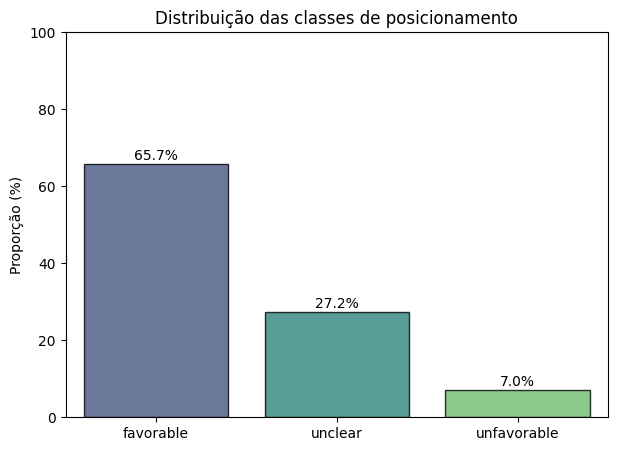

In [8]:
plt.figure(figsize=(7,5))

ax = sns.countplot(
    data = dados,
    x = 'Corrected_stance',
    stat='percent',
    hue = 'Corrected_stance',
    edgecolor = 'black',
    alpha=0.8,
    palette='viridis'
)

for container in ax.containers:
    ax.bar_label(
    container,
    labels=[f'{val:.1f}%' for val in container.datavalues],
    padding = 1
    )

plt.title('Distribuição das classes de posicionamento')
plt.ylabel('Proporção (%)')
plt.xlabel('')
plt.ylim(0, 100)

### Nuvem de palavras

Separa *content* em textos favoráveis e unclear, de um lado, e desfavoráveis, de outro

In [9]:
textos_fav_unc = dados[(dados['Corrected_stance'] == 'favorable') | (dados['Corrected_stance'] == 'unclear')]['content']
textos_desfav = dados[dados['Corrected_stance'] == 'unfavorable']['content']

Coloca tudo em uma string somente

In [10]:
textos_fav_unc = " ".join(textos_fav_unc)
textos_desfav = " ".join(textos_desfav)

Função para processar o texto

In [11]:
def text_preprocess(texto):
    # Converte tudo para minúsculo
    texto = texto.lower()
    # Remove URLs
    texto = re.sub(r'https://\S+', '', texto)
    # Remove quebra de linha
    texto = texto.replace('\\n', ' ')
    # Remove hashtags
    texto = re.sub(r'#(\w+)', r'\n', texto)
    # Normaliza o texto para remover acentos e caracteres especiais
    texto = unicodedata.normalize('NFKD', texto).encode('ASCII', 'ignore').decode('ASCII')
    # Seleciona apenas as palavras
    #texto = re.findall(r'\w+', texto)
    texto = re.findall(r'[a-záàâãéêíóôõúç]+', texto)
    # Junta o texto, porque o .findall cria tokens
    texto = " ".join(texto)

    return texto

In [12]:
textos_fav_unc = text_preprocess(textos_fav_unc)
textos_desfav = text_preprocess(textos_desfav)

Função para remover stopwords

In [13]:
# Instalar pt_core_news_sm para rodar spacy.load('pt_core_news_sm')
# !python -m spacy download pt_core_news_sm

In [14]:
nlp = spacy.load('pt_core_news_sm')

def remover_stopwords(texto):
    doc = nlp(texto)
    # Filtrar as palavras que não são stopwords
    texto_sem_stopwords = [token.text for token in doc if not token.is_stop]
    # Juntar as palavras de volta em uma string
    return " ".join(texto_sem_stopwords)

In [15]:
textos_fav_unc = remover_stopwords(textos_fav_unc)
textos_desfav = remover_stopwords(textos_desfav)

In [16]:
textos_fav_unc = textos_fav_unc.replace(' vacina ', '')
textos_desfav = textos_desfav.replace(' vacina ', '')

Função para gerar nuvem de palavras

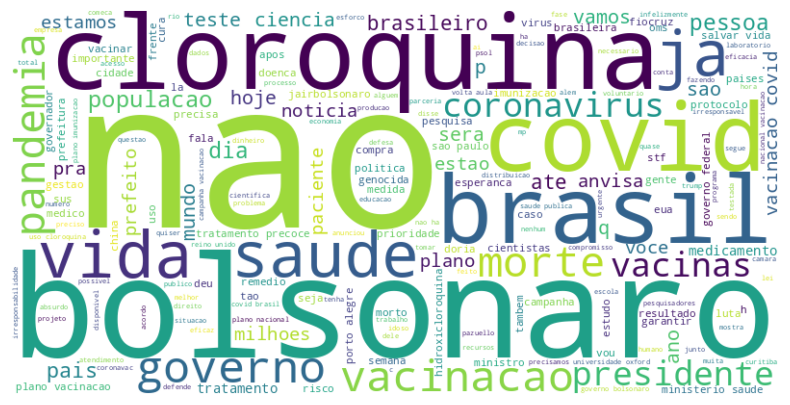

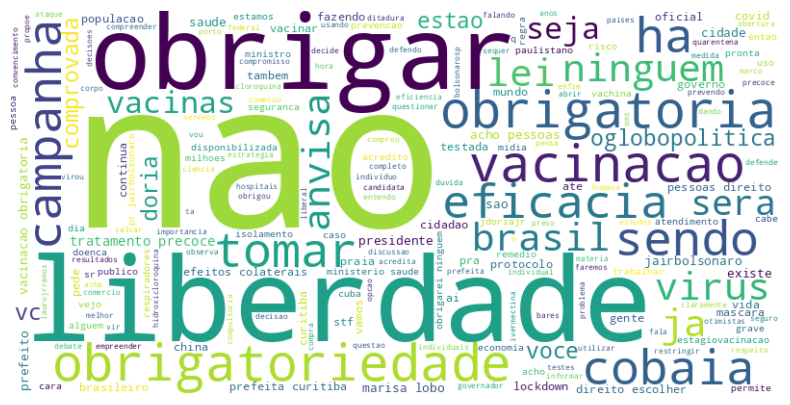

In [17]:
def gerar_nuvem(texto, titulo):
    wordcloud = WordCloud(width=800, height=400, random_state=123, background_color='white').generate(texto)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(titulo, fontsize=20)
    plt.show()

gerar_nuvem(textos_fav_unc, "")
gerar_nuvem(textos_desfav, "")

## **4. Pré-processamento**

### Feature-Target-Split

In [18]:
target = dados['Corrected_stance']
features = dados['content']

### Target: Label Encoding

In [19]:
target = target.map({'favorable':0, 'unclear':0, 'unfavorable':1})

### Features: Text Preprocessing

#### Removendo ruídos

In [20]:
features = features.apply(text_preprocess)

#### Lematização

In [21]:
nlp = spacy.load("pt_core_news_sm")
# Função de pré-processamento com lematização
def lematization(texto):
    # Processar o texto com spaCy
    doc = nlp(texto)
    # Extrair apenas os lemas das palavras
    lemas = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    # Juntar os lemas em uma única string
    return " ".join(lemas)

In [22]:
features = features.apply(lematization)

In [23]:
features

0       cabeca pensar pe pisa governar escritorio ar c...
1       sarto programa enfrentamento pandemia garantir...
2       camar deputado votar hoje mp tratar adesao Bra...
3       tirar bolsonaro questao vida morte presidente ...
4       liesa decidir adiar desfile data nao pensar sa...
                              ...                        
2981    dermatologista ligia kogos receitar hidroxiclo...
2984    sabar china injetar vacina combate coronavirus...
2989    fabricacao cloroquina forca armado subir cerca...
2992    Brasil receber cloroquina EUA ampliar uso trat...
2995    defesa brasileiro assinar manifesto q ressalta...
Name: content, Length: 1407, dtype: object

### Train-Test-Split

In [24]:
x_treino, x_teste, y_treino, y_teste = train_test_split(
    features,
    target,
    test_size = 0.2,
    shuffle = True,
    stratify = target,
    random_state = 123
)

In [25]:
print(f'Treino:\n\n{y_treino.value_counts(normalize=True)}')
print('\n')
print(f'Teste:\n\n{y_teste.value_counts(normalize=True)}')

Treino:

Corrected_stance
0    0.929778
1    0.070222
Name: proportion, dtype: float64


Teste:

Corrected_stance
0    0.929078
1    0.070922
Name: proportion, dtype: float64


### Vetorização com Bag of Words

In [26]:
nltk.download('stopwords')

[nltk_data] Error loading stopwords: <urlopen error [Errno 11001]
[nltk_data]     getaddrinfo failed>


False

In [27]:
# Lista das stops words do português
stop_words_pt = stopwords.words('portuguese')

# Vetorizador
vectorizer = CountVectorizer(
    stop_words = stop_words_pt,
    ngram_range = (1,1)
)

#### Features de treino

In [28]:
# Aplicando o Bow na base de treino
x_treino_bow = vectorizer.fit_transform(x_treino)
# Transforma em um data frame
x_treino_bow = pd.DataFrame(x_treino_bow.toarray())

#### Features de teste

In [29]:
# Aplica o BoW na base de teste
x_teste_bow = vectorizer.transform(x_teste)
# Transforma em um data frame
x_teste_bow = pd.DataFrame(x_teste_bow.toarray())

## **5. Baseline**

### Baselines ingênuos

Se criássemos um modelo que sempre classifica nossos tweets como zero (0), valor correspondente às classes *favorável* e *unclear*, teríamos uma acurácia de 93%. Vejamos porque:

In [30]:
modelo_dummy = DummyClassifier(strategy='most_frequent')
modelo_dummy.fit(x_treino_bow, y_treino)
print(f'Acurácia: {round(modelo_dummy.score(x_treino_bow, y_treino),2)}')

Acurácia: 0.93


Já que nosso objetivo é prever corretamente a classe *desfavorável*, se nosso modelo sempre classificasse como um (1) teríamos uma performance de apenas 7%.

In [31]:
modelo_dummy = DummyClassifier(strategy='constant', constant=1)
modelo_dummy.fit(x_treino_bow, y_treino)
print(f'Acurácia: {round(modelo_dummy.score(x_treino_bow, y_treino),2)}')

Acurácia: 0.07


Vamos, por fim, simular um modelo que classifica os tweets de maneira aleatória e verificar sua performance.

In [32]:
modelo_dummy = DummyClassifier(strategy='uniform')
modelo_dummy.fit(x_treino_bow, y_treino)
print(f'Acurácia: {round(modelo_dummy.score(x_treino_bow, y_treino),2)}')

Acurácia: 0.51


### Baseline Logístico

#### K-Fold Cross Validation

Nesta seção, vamos fazer definir os critérios da separação dos nossos dados em *folds* (dobras) e, depois, em treino e validação.

In [33]:
# x_treino, x_teste, y_treino, y_teste = train_test_split(
#     features,
#     target,
#     test_size = 0.2,
#     shuffle = True,
#     stratify = target,
#     random_state = 100
# )

In [34]:
# Definição do número de folds
kf = skm.KFold(
    n_splits=10,
    shuffle=True,
    random_state=123
)

# Definição dos folds
for i, (train_index, test_index) in enumerate(kf.split(x_treino)):
    print(f'Fold: {i}')
    print(f'  Treino: tamanho = {len(train_index)}')
    print(f'  Teste: tamanho = {len(test_index)}')

Fold: 0
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 1
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 2
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 3
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 4
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 5
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 6
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 7
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 8
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 9
  Treino: tamanho = 1013
  Teste: tamanho = 112


Vamos novamente chamar o vetorizador, apenas para explicitar que devemos usá-lo no processo de separação entre treino e validação. Se usássemos o objeto `x_treino_bow` que criamos anteriormente, estaríamos correndo o risco de cometer *data leakage*, pois o método `fit_transform` ajusta o vocabulário do vetorizador a todos os dados de treino. Desse modo, ele seria aplicado a toda a base de treino (antes da validação cruzada), o que faz com que o vetor de características tenha acesso a todos os dados de treino, incluindo informações que não deveriam ser utilizadas durante o treinamento de cada fold no K-Fold.

Para evitar o data leakage, o ajuste do vetorizador (fit) deve ocorrer dentro do loop de validação cruzada. Isso garante que o vocabulário seja ajustado somente com os dados de treino de cada fold.

In [35]:
# Vetorizador
vectorizer = CountVectorizer(
    stop_words = stop_words_pt,
    ngram_range = (1,1)
    )

In [36]:
# Cria um dataframe vazio para armazenar as métricas
resultados = []

In [37]:
# Ajuste dos inputs
y_treino_array = y_treino.to_numpy()

# Loop de treinamento
for i, (train_index, test_index) in enumerate(kf.split(x_treino)):
    # Separação entre treino e validacao
    x_treino_kf, x_validacao_kf = x_treino.iloc[train_index], x_treino.iloc[test_index]
    y_treino_kf, y_validacao_kf = y_treino_array[train_index], y_treino_array[test_index]
    # Aplica o vetorizador
    x_treino_kf_bow = vectorizer.fit_transform(x_treino_kf)
    x_validacao_kf_bow = vectorizer.transform(x_validacao_kf)
    # Treinamento do modelo
    modelo_logistico = LogisticRegression()
    # Ajuste do modelo
    modelo_logistico.fit(x_treino_kf_bow, y_treino_kf)
    # Faz as predições
    y_pred_logistico_kf = modelo_logistico.predict(x_validacao_kf_bow)
    # Armazena as métricas
    metricas_kf = precision_recall_fscore_support(
        y_validacao_kf,
        y_pred_logistico_kf,
        average = None,
        labels = [0, 1],
        zero_division = True
    )
    # Desempacota os valores
    precision, recall, f1, suporte = metricas_kf
    # Cria dicionário com os resultados
    metricas_dicio = {
        'precision':precision,
        'recall':recall,
        'f1':f1,
        'suporte':suporte,
        'fold':i
    }
    # Converte o dicionário para data frame
    metricas_df = pd.DataFrame(metricas_dicio)
    # Converte o index em uma coluna
    metricas_df.reset_index(inplace=True)
    # Renomeia a coluna
    metricas_df = metricas_df.rename(columns={'index':'classe'})
    # Adiciona o DataFrame à lista
    resultados.append(metricas_df)

# Coloca os resultados dentro do dataframe criado fora do loop
resultados_baseline = pd.concat(resultados, axis = 0)

In [38]:
resultados_baseline['classe'] = resultados_baseline['classe'].map({0:'favorável + unclear', 1:'desfavorável'})
resultados_baseline.reset_index(drop=True, inplace=True)

In [39]:
resultados_melted_baseline = resultados_baseline.melt(
    id_vars=['classe', 'suporte', 'fold'],
    value_vars=['precision', 'recall', 'f1'],
    var_name='metricas',
    value_name='valores'
)

In [40]:
resultados_melted_baseline['modelo'] = 'Regressão Logística (baseline)'

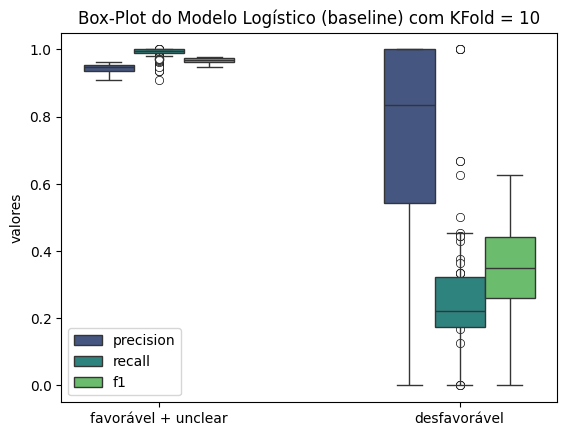

In [41]:
sns.boxplot(
    resultados_melted_baseline,
    x = 'classe',
    y = 'valores',
    hue = 'metricas',
    palette='viridis',
    width=0.5
)
sns.scatterplot(
    data = resultados_melted_baseline,
    x = 'classe',
    y = 'valores',
    color = 'white',
    edgecolor = 'black'
)
plt.title('Box-Plot do Modelo Logístico (baseline) com KFold = 10')
plt.xlabel('')
plt.legend(loc='lower left')
#plt.annotate('Desempenho na base de validação', xy = (0,0))

#### Desempenho no banco de teste

##### Relatório de Classificação

In [42]:
# Instancia o modelo de regressão logística
modelo_logistico = LogisticRegression()
# Ajustando o modelo
modelo_logistico.fit(x_treino_bow, y_treino)
# Prevendo no banco de teste
y_pred_logistico_baseline = modelo_logistico.predict(x_teste_bow)
# Métricas
print(f'Acurácia: {accuracy_score(y_teste, y_pred_logistico_baseline)}')
print('')
print(f'Relatório de Classificação: \n{classification_report(y_teste, y_pred_logistico_baseline)}')

Acurácia: 0.9574468085106383

Relatório de Classificação: 
              precision    recall  f1-score   support

           0       0.96      1.00      0.98       262
           1       1.00      0.40      0.57        20

    accuracy                           0.96       282
   macro avg       0.98      0.70      0.77       282
weighted avg       0.96      0.96      0.95       282



Com base nos resultados acima e atendo-se somente à classe 1 (desfavorável), podemos ver que a precisão do modelo é excelente: todas as previsões feitas como "desfavorável" estavam corretas; o modelo não teve nenhum falso positivo para essa classe. Porém, quanto ao recall, temos resultados insatisfatórios. O modelo conseguiu identificar apenas 35% dos tweets realmente desfavoráveis, ou seja, ele perdeu 65% das instâncias dessa classe (falsos negativos). O baixo recall indica que o modelo não está capturando muitas instâncias da classe desfavorável, talvez por estar enviesado para a classe majoritária (classe 0).

##### Matriz de Confusão

In [43]:
# Visualiza ordem das classes
class_order = np.unique(y_teste)
print("Ordem das classes:", class_order)

Ordem das classes: [0 1]


Text(0.5, 1.0, 'Matriz de Confusão')

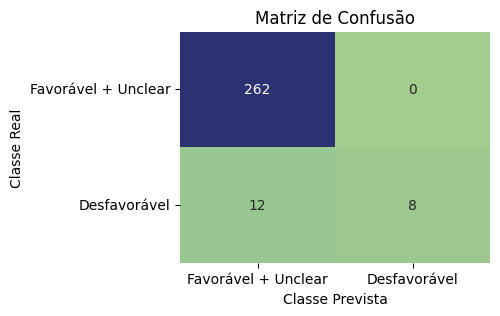

In [44]:
matriz_conf = confusion_matrix(y_teste, y_pred_logistico_baseline)
nome_classes = ['Favorável + Unclear', 'Desfavorável']

plt.figure(figsize=(4,3))
sns.heatmap(
    matriz_conf,
    annot=True,
    fmt='d',
    cmap='crest',
    xticklabels=nome_classes,
    yticklabels=nome_classes,
    cbar=False
)
plt.xlabel('Classe Prevista', )
plt.ylabel('Classe Real')
plt.title('Matriz de Confusão')

## **6. Modelos e Resultados**

### Parâmetros para cada modelo

In [45]:
# Modelo 1: Regressão Logística
param_grid_reg_log = {
    'C': [0.01, 0.1, 0.5, 1, 10],
    'solver': ['lbfgs', 'sag', 'saga'],
    'class_weight': ['balanced'],
    'penalty': ['l2'],
    'max_iter': [100, 200, 500, 1000]
}
# Modelo 2: Árvore de Decisão
param_grid_arvore = {
    'max_depth': [5, 10, 20, 30, 50],
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 5, 10],
    'max_features': ['auto', 'sqrt', 'log2', None],
    'criterion': ['gini', 'entropy']
}
# Modelo 3: SVC
param_grid_svc = {
    'C': [0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
    'gamma': ['scale', 'auto', 0.1, 1],
    'degree': [2, 3, 4],
    'class_weight': [None, 'balanced']
}
# Modelo 4: Naive Bayes
param_grid_naive_bayes = {
    'alpha': [0.01, 0.1, 0.5, 1.0, 10],
    'fit_prior': [True, False]
}
# Modelo 5: Gradient Boosting
param_grid_gradient_boosting = {
    'learning_rate': [0.01, 0.05, 0.1, 0.5, 1],
    'n_estimators': [50, 100, 200, 500],
    'max_depth': [3, 5, 7, 10],
    'subsample': [0.8, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 5],
    'loss': ['deviance', 'exponential']
}

### Grid Search

In [46]:
random_reg_log = RandomizedSearchCV(
    LogisticRegression(random_state=123),
    param_distributions=param_grid_reg_log,
    cv=5,
    scoring='recall',
    n_jobs=-1
)
random_arvore = RandomizedSearchCV(
    DecisionTreeClassifier(random_state=123),
    param_distributions=param_grid_arvore,
    cv=5,
    scoring='recall',
    n_jobs=-1
)
random_SVC = RandomizedSearchCV(
    SVC(random_state=123, probability=True),
    param_distributions=param_grid_svc,
    cv=5,
    scoring='recall',
    n_jobs=-1
)
random_naive_bayes = RandomizedSearchCV(
    MultinomialNB(),
    param_distributions=param_grid_naive_bayes,
    cv=5,
    scoring='recall',
    n_jobs=-1
)
random_gradient_boosting = RandomizedSearchCV(
    GradientBoostingClassifier(random_state=123),
    param_distributions=param_grid_gradient_boosting,
    cv=5,
    scoring='recall',
    n_jobs=-1
)

### Treinamento

In [47]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
random_reg_log.fit(x_treino_bow, y_treino)
random_arvore.fit(x_treino_bow, y_treino)
random_SVC.fit(x_treino_bow, y_treino)
random_naive_bayes.fit(x_treino_bow, y_treino)
random_gradient_boosting.fit(x_treino_bow, y_treino)

### Melhores estimadores

In [ ]:
best_reg_log = random_reg_log.best_estimator_
best_arvore = random_arvore.best_estimator_
best_svc = random_SVC.best_estimator_
best_naive_bayes = random_naive_bayes.best_estimator_
best_gradient_boosting = random_gradient_boosting.best_estimator_

In [ ]:
print(f'Regressão Logística: {random_reg_log.best_params_}')
print(f'Árvore de Decisão: {random_arvore.best_params_}')
print(f'SVC: {random_SVC.best_params_}')
print(f'Multinomial Naive Bayes: {random_naive_bayes.best_params_}')
print(f'Gradient Boosting: {random_gradient_boosting.best_params_}')

Regressão Logística: {'solver': 'sag', 'penalty': 'l2', 'max_iter': 500, 'class_weight': 'balanced', 'C': 0.01}
Árvore de Decisão: {'min_samples_split': 5, 'min_samples_leaf': 10, 'max_features': None, 'max_depth': 30, 'criterion': 'entropy'}
SVC: {'kernel': 'rbf', 'gamma': 'auto', 'degree': 2, 'class_weight': 'balanced', 'C': 1}
Multinomial Naive Bayes: {'fit_prior': False, 'alpha': 0.1}
Gradient Boosting: {'subsample': 0.8, 'n_estimators': 200, 'min_samples_split': 10, 'min_samples_leaf': 5, 'max_depth': 10, 'loss': 'exponential', 'learning_rate': 0.5}


### K-Fold Cross Validation

In [ ]:
# Definição do número de folds
kf = skm.KFold(
    n_splits=10,
    shuffle=True,
    random_state=123
)

# Definição dos folds
for i, (train_index, test_index) in enumerate(kf.split(x_treino)):
    print(f'Fold: {i}')
    print(f'  Treino: tamanho = {len(train_index)}')
    print(f'  Teste: tamanho = {len(test_index)}')

Fold: 0
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 1
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 2
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 3
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 4
  Treino: tamanho = 1012
  Teste: tamanho = 113
Fold: 5
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 6
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 7
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 8
  Treino: tamanho = 1013
  Teste: tamanho = 112
Fold: 9
  Treino: tamanho = 1013
  Teste: tamanho = 112


In [ ]:
# Vetorizador
vectorizer = CountVectorizer(
    stop_words = stop_words_pt,
    ngram_range = (1,1)
)

In [ ]:
# Ajuste dos inputs
y_treino_array = y_treino.to_numpy()

# Modelos a serem testados
modelos = {
    'Regressão Logística': best_reg_log,
    'Árvore de Decisão': best_arvore,
    'SVC': best_svc,
    'Multinomial Naive Bayes': best_naive_bayes,
    'Gradient Boosting': best_gradient_boosting
}

resultados = []

# Loop de treinamento
for i, (train_index, test_index) in enumerate(kf.split(x_treino)):
    # Separação entre treino e validacao
    x_treino_kf, x_validacao_kf = x_treino.iloc[train_index], x_treino.iloc[test_index]
    y_treino_kf, y_validacao_kf = y_treino_array[train_index], y_treino_array[test_index]
    # Aplica o vetorizador
    x_treino_kf_bow = vectorizer.fit_transform(x_treino_kf)
    x_validacao_kf_bow = vectorizer.transform(x_validacao_kf)
    # Treinamento dos modelos
    for nome_modelo, modelo in modelos.items():
        # Treinamento do modelo
        modelo.fit(x_treino_kf_bow, y_treino_kf)
        # Previsões
        y_pred = modelo.predict(x_validacao_kf_bow)
        # Calculando as métricas
        precision, recall, f1, suporte = precision_recall_fscore_support(
            y_validacao_kf,
            y_pred,
            average=None,
            labels=[0, 1],
            zero_division=True
        )
        # Armazenando os resultados no DataFrame
        metricas_dicio = {
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'suporte': suporte,
            'fold': i,
            'modelo': nome_modelo
        }
        # Cria um DataFrame a partir do dicionário e acumula os resultados
        metricas_df = pd.DataFrame(metricas_dicio)
        # Converte o index em uma coluna
        metricas_df.reset_index(inplace=True)
        # Renomeia a coluna
        metricas_df = metricas_df.rename(columns={'index':'classe'})
        # Armazena na lista
        resultados.append(metricas_df)

# Junta tudo
resultados = pd.concat(resultados, axis=0)

# Exibe o DataFrame com as métricas de todos os modelos e folds
resultados.reset_index(drop=True, inplace=True)

In [ ]:
resultados['classe'] = resultados['classe'].map({0:'favorável + unclear', 1:'desfavorável'})
resultados.reset_index(drop=True, inplace=True)

In [ ]:
resultados_melted = resultados.melt(
    id_vars=['classe', 'suporte', 'fold', 'modelo'],
    value_vars=['precision', 'recall', 'f1'],
    var_name='metricas',
    value_name='valores'
)

In [ ]:
resultados_final = pd.concat([resultados_melted, resultados_melted_baseline])

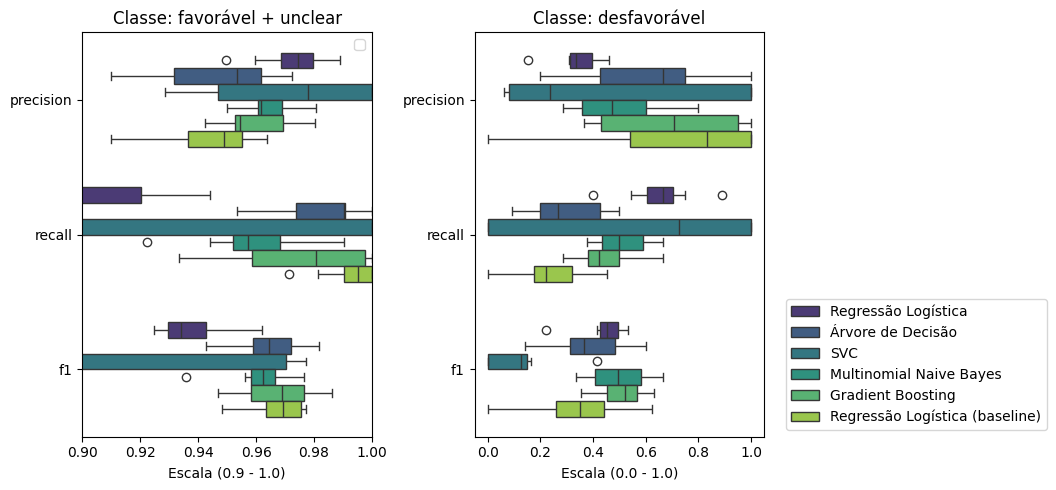

In [ ]:
plt.figure(figsize=(12,5))

plt.subplot(1, 2, 1)
sns.boxplot(
    data = resultados_final[resultados_final['classe'] == 'favorável + unclear'],
    y = 'metricas',
    x = 'valores',
    hue = 'modelo',
    #color='classe',
    palette='viridis',
    width=0.7
)
plt.title('Classe: favorável + unclear')
plt.ylabel('')
plt.xlabel('Escala (0.9 - 1.0)')
plt.legend('')
plt.xlim(0.9,1)

plt.subplot(1, 2, 2)
sns.boxplot(
    data = resultados_final[resultados_final['classe'] == 'desfavorável'],
    y = 'metricas',
    x = 'valores',
    hue = 'modelo',
    #color='classe',
    palette='viridis',
    width=0.7
)
plt.title('Classe: desfavorável')
plt.ylabel('')
plt.xlabel('Escala (0.0 - 1.0)')
plt.legend(title='', loc='lower right', bbox_to_anchor=(2, 0))
plt.tight_layout()

### Matriz de Confusão

Text(992.81045751634, 0.5, '')

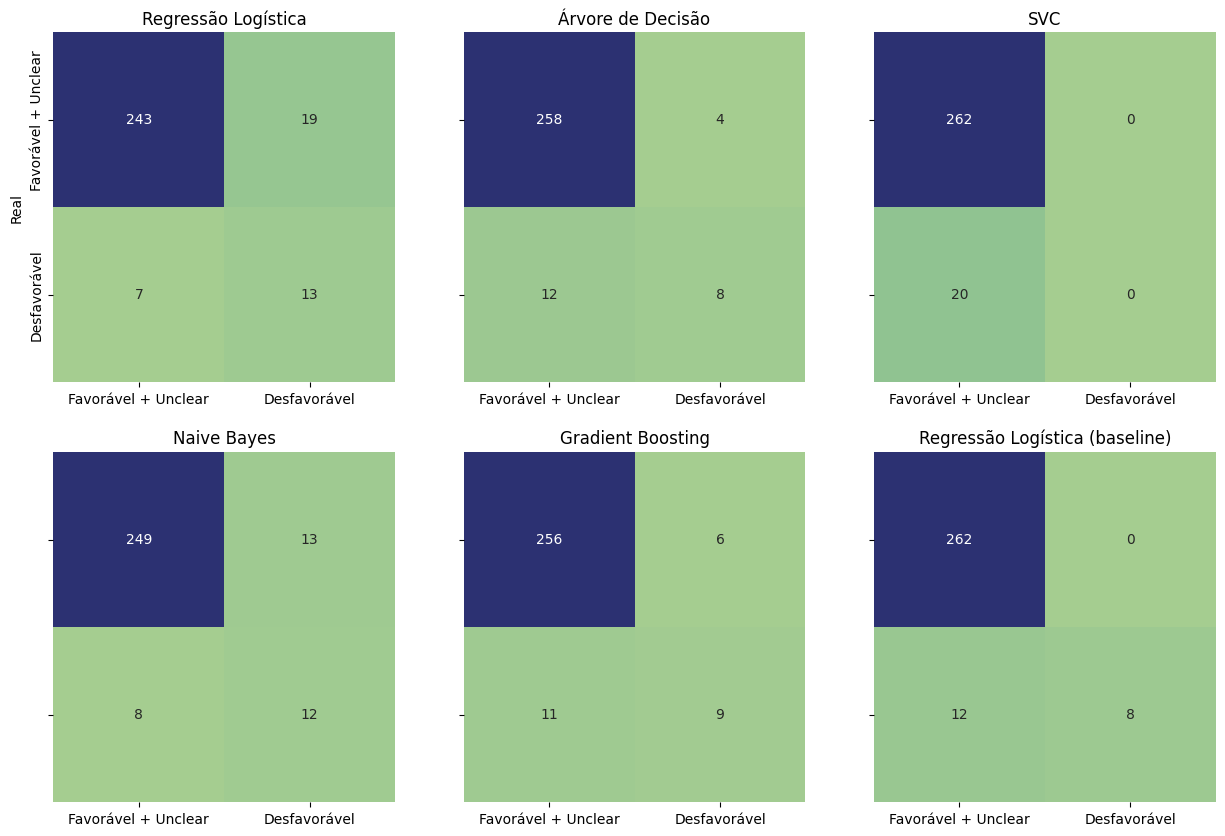

In [ ]:
from sklearn.metrics import confusion_matrix

best_reg_log.fit(x_treino_bow, y_treino)
y_pred1 = best_reg_log.predict(x_teste_bow)

best_arvore.fit(x_treino_bow, y_treino)
y_pred2 = best_arvore.predict(x_teste_bow)

best_svc.fit(x_treino_bow, y_treino)
y_pred3 = best_svc.predict(x_teste_bow)

best_naive_bayes.fit(x_treino_bow, y_treino)
y_pred4 = best_naive_bayes.predict(x_teste_bow)

best_gradient_boosting.fit(x_treino_bow, y_treino)
y_pred5 = best_gradient_boosting.predict(x_teste_bow)

modelo_logistico.fit(x_treino_bow, y_treino)
y_pred6 = modelo_logistico.predict(x_teste_bow)

# Plotando o gráfico de mapa de calor para a matriz combinada
plt.figure(figsize=(15, 10))

### Modelo de Regressão Logística
plt.subplot(2, 3, 1)
sns.heatmap(
    confusion_matrix(y_teste, y_pred1),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['Favorável + Unclear', 'Desfavorável'],
    cbar=False
    )

plt.title("Regressão Logística")
plt.xlabel("")
plt.ylabel("Real")


### Modelo de Árvore de Decisão
plt.subplot(2, 3, 2)
sns.heatmap(
    confusion_matrix(y_teste, y_pred2),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['', ''],
    cbar=False
    )

plt.title("Árvore de Decisão")
plt.xlabel("")
plt.ylabel("")

### Modelo SVC
plt.subplot(2, 3, 3)
sns.heatmap(
    confusion_matrix(y_teste, y_pred3),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['', ''],
    cbar=False
)

plt.title("SVC")
plt.xlabel("")
plt.ylabel("")

### Modelo Naive Bayes
plt.subplot(2, 3, 4)
sns.heatmap(
    confusion_matrix(y_teste, y_pred4),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['', ''],
    cbar=False
)

plt.title("Naive Bayes")
plt.xlabel("")
plt.ylabel("")

### Modelo Gradient Boosting
plt.subplot(2, 3, 5)
sns.heatmap(
    confusion_matrix(y_teste, y_pred5),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['', ''],
    cbar=False
)

plt.title("Gradient Boosting")
plt.xlabel("")
plt.ylabel("")

### Modelo de Regressão Logística (baseline)
plt.subplot(2, 3, 6)
sns.heatmap(
    confusion_matrix(y_teste, y_pred6),
    annot=True,
    fmt="d",
    cmap="crest",
    xticklabels=['Favorável + Unclear', 'Desfavorável'],
    yticklabels=['', ''],
    cbar=False
)

plt.title("Regressão Logística (baseline)")
plt.xlabel("")
plt.ylabel("")

In [ ]:
print(f'Regressão Logística:\n{classification_report(y_teste, y_pred1)}')
print('')
print(f'Árvore de Decisão:\n{classification_report(y_teste, y_pred2)}')
print('')
print(f'SVC:\n{classification_report(y_teste, y_pred3)}')
print('')
print(f'Naive Bayes:\n{classification_report(y_teste, y_pred4)}')
print('')
print(f'Gradient Boosting:\n{classification_report(y_teste, y_pred6)}')
print('')
print(f'Regressão Logística (baseline):\n{classification_report(y_teste, y_pred_logistico_baseline)}')